In [1]:
import gym
import numpy as np
import math
from collections import deque
import time
import matplotlib
import matplotlib.pyplot as plt

class MountaincarQAgent():
    def __init__(self, buckets=(12, 12), num_episodes=500000, min_epsilon=0.01, discount=0.99, decay=100, force=True):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]
        
        ## Concatination of tuples to get shape (12,12,3) for buckets=(12, 12)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))        
        
        self.learning_rate = 0.008
        
        self.threshold = self.env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize_state(self, obs):
        discretized = list()
        for i in range(len(obs)):
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []  
        print_every = 400
        time_start = time.time()
        
        for i_episode in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            done = False
            
            episode_reward = 0
            time_step = 0
            
            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)   
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                episode_reward += reward
                
            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:                
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, episode_reward, avg_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if avg_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                

        print('Finished training!')
        
        return scores_array, avg_scores_array

    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    
    def close(self):
        self.env.close()

In [2]:
agent = MountaincarQAgent()
scores, avg_scores = agent.train()

threshold:  -110.0
Episode: 400, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.40, Time: 00:00:02
Episode: 800, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.10, Time: 00:00:04
Episode: 1200, Timesteps:  200, Score: -200.0,  Avg.Score: -199.62, eps-greedy:  0.01, Time: 00:00:06
Episode: 1600, Timesteps:  200, Score: -200.0,  Avg.Score: -199.84, eps-greedy:  0.01, Time: 00:00:09
Episode: 2000, Timesteps:  193, Score: -193.0,  Avg.Score: -196.12, eps-greedy:  0.01, Time: 00:00:11
Episode: 2400, Timesteps:  200, Score: -200.0,  Avg.Score: -198.42, eps-greedy:  0.01, Time: 00:00:13
Episode: 2800, Timesteps:  173, Score: -173.0,  Avg.Score: -182.97, eps-greedy:  0.01, Time: 00:00:16
Episode: 3200, Timesteps:  200, Score: -200.0,  Avg.Score: -193.94, eps-greedy:  0.01, Time: 00:00:18
Episode: 3600, Timesteps:  200, Score: -200.0,  Avg.Score: -192.51, eps-greedy:  0.01, Time: 00:00:20
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -197.7

Episode: 32400, Timesteps:  144, Score: -144.0,  Avg.Score: -150.22, eps-greedy:  0.01, Time: 00:02:52
Episode: 32800, Timesteps:  158, Score: -158.0,  Avg.Score: -158.73, eps-greedy:  0.01, Time: 00:02:54
Episode: 33200, Timesteps:  147, Score: -147.0,  Avg.Score: -147.05, eps-greedy:  0.01, Time: 00:02:56
Episode: 33600, Timesteps:  162, Score: -162.0,  Avg.Score: -146.59, eps-greedy:  0.01, Time: 00:02:57
Episode: 34000, Timesteps:  106, Score: -106.0,  Avg.Score: -142.92, eps-greedy:  0.01, Time: 00:02:59
Episode: 34400, Timesteps:  160, Score: -160.0,  Avg.Score: -144.71, eps-greedy:  0.01, Time: 00:03:01
Episode: 34800, Timesteps:  154, Score: -154.0,  Avg.Score: -149.81, eps-greedy:  0.01, Time: 00:03:03
Episode: 35200, Timesteps:  163, Score: -163.0,  Avg.Score: -142.02, eps-greedy:  0.01, Time: 00:03:05
Episode: 35600, Timesteps:  106, Score: -106.0,  Avg.Score: -143.02, eps-greedy:  0.01, Time: 00:03:07
Episode: 36000, Timesteps:  155, Score: -155.0,  Avg.Score: -142.64, eps-

Episode: 64400, Timesteps:  161, Score: -161.0,  Avg.Score: -140.05, eps-greedy:  0.01, Time: 00:05:31
Episode: 64800, Timesteps:  120, Score: -120.0,  Avg.Score: -163.51, eps-greedy:  0.01, Time: 00:05:33
Episode: 65200, Timesteps:  149, Score: -149.0,  Avg.Score: -147.51, eps-greedy:  0.01, Time: 00:05:35
Episode: 65600, Timesteps:  144, Score: -144.0,  Avg.Score: -146.50, eps-greedy:  0.01, Time: 00:05:37
Episode: 66000, Timesteps:  183, Score: -183.0,  Avg.Score: -156.37, eps-greedy:  0.01, Time: 00:05:39
Episode: 66400, Timesteps:  144, Score: -144.0,  Avg.Score: -140.15, eps-greedy:  0.01, Time: 00:05:41
Episode: 66800, Timesteps:  161, Score: -161.0,  Avg.Score: -142.05, eps-greedy:  0.01, Time: 00:05:43
Episode: 67200, Timesteps:  149, Score: -149.0,  Avg.Score: -138.49, eps-greedy:  0.01, Time: 00:05:45
Episode: 67600, Timesteps:  108, Score: -108.0,  Avg.Score: -142.14, eps-greedy:  0.01, Time: 00:05:46
Episode: 68000, Timesteps:  163, Score: -163.0,  Avg.Score: -141.13, eps-

Episode: 96400, Timesteps:  161, Score: -161.0,  Avg.Score: -160.46, eps-greedy:  0.01, Time: 00:07:52
Episode: 96800, Timesteps:  140, Score: -140.0,  Avg.Score: -144.68, eps-greedy:  0.01, Time: 00:07:54
Episode: 97200, Timesteps:  154, Score: -154.0,  Avg.Score: -145.18, eps-greedy:  0.01, Time: 00:07:56
Episode: 97600, Timesteps:  172, Score: -172.0,  Avg.Score: -142.18, eps-greedy:  0.01, Time: 00:07:57
Episode: 98000, Timesteps:  146, Score: -146.0,  Avg.Score: -152.11, eps-greedy:  0.01, Time: 00:07:59
Episode: 98400, Timesteps:  123, Score: -123.0,  Avg.Score: -162.27, eps-greedy:  0.01, Time: 00:08:01
Episode: 98800, Timesteps:  200, Score: -200.0,  Avg.Score: -155.01, eps-greedy:  0.01, Time: 00:08:03
Episode: 99200, Timesteps:  200, Score: -200.0,  Avg.Score: -197.10, eps-greedy:  0.01, Time: 00:08:05
Episode: 99600, Timesteps:  189, Score: -189.0,  Avg.Score: -193.92, eps-greedy:  0.01, Time: 00:08:08
Episode: 100000, Timesteps:  168, Score: -168.0,  Avg.Score: -151.44, eps

Episode: 128000, Timesteps:  142, Score: -142.0,  Avg.Score: -140.86, eps-greedy:  0.01, Time: 00:10:15
Episode: 128400, Timesteps:  108, Score: -108.0,  Avg.Score: -136.29, eps-greedy:  0.01, Time: 00:10:17
Episode: 128800, Timesteps:  140, Score: -140.0,  Avg.Score: -141.28, eps-greedy:  0.01, Time: 00:10:19
Episode: 129200, Timesteps:  161, Score: -161.0,  Avg.Score: -143.40, eps-greedy:  0.01, Time: 00:10:21
Episode: 129600, Timesteps:  141, Score: -141.0,  Avg.Score: -139.89, eps-greedy:  0.01, Time: 00:10:23
Episode: 130000, Timesteps:  158, Score: -158.0,  Avg.Score: -139.37, eps-greedy:  0.01, Time: 00:10:24
Episode: 130400, Timesteps:  162, Score: -162.0,  Avg.Score: -142.36, eps-greedy:  0.01, Time: 00:10:26
Episode: 130800, Timesteps:  200, Score: -200.0,  Avg.Score: -155.25, eps-greedy:  0.01, Time: 00:10:28
Episode: 131200, Timesteps:  134, Score: -134.0,  Avg.Score: -136.75, eps-greedy:  0.01, Time: 00:10:30
Episode: 131600, Timesteps:  166, Score: -166.0,  Avg.Score: -14

Episode: 159600, Timesteps:  145, Score: -145.0,  Avg.Score: -146.01, eps-greedy:  0.01, Time: 00:12:44
Episode: 160000, Timesteps:  109, Score: -109.0,  Avg.Score: -141.60, eps-greedy:  0.01, Time: 00:12:45
Episode: 160400, Timesteps:  149, Score: -149.0,  Avg.Score: -150.54, eps-greedy:  0.01, Time: 00:12:47
Episode: 160800, Timesteps:  147, Score: -147.0,  Avg.Score: -145.85, eps-greedy:  0.01, Time: 00:12:49
Episode: 161200, Timesteps:  171, Score: -171.0,  Avg.Score: -149.27, eps-greedy:  0.01, Time: 00:12:51
Episode: 161600, Timesteps:  145, Score: -145.0,  Avg.Score: -146.82, eps-greedy:  0.01, Time: 00:12:52
Episode: 162000, Timesteps:  145, Score: -145.0,  Avg.Score: -150.85, eps-greedy:  0.01, Time: 00:12:54
Episode: 162400, Timesteps:  157, Score: -157.0,  Avg.Score: -159.27, eps-greedy:  0.01, Time: 00:12:56
Episode: 162800, Timesteps:  111, Score: -111.0,  Avg.Score: -149.61, eps-greedy:  0.01, Time: 00:12:58
Episode: 163200, Timesteps:  108, Score: -108.0,  Avg.Score: -14

Episode: 191200, Timesteps:  160, Score: -160.0,  Avg.Score: -140.48, eps-greedy:  0.01, Time: 00:15:02
Episode: 191600, Timesteps:  143, Score: -143.0,  Avg.Score: -139.42, eps-greedy:  0.01, Time: 00:15:04
Episode: 192000, Timesteps:  162, Score: -162.0,  Avg.Score: -146.01, eps-greedy:  0.01, Time: 00:15:06
Episode: 192400, Timesteps:  142, Score: -142.0,  Avg.Score: -141.99, eps-greedy:  0.01, Time: 00:15:08
Episode: 192800, Timesteps:  153, Score: -153.0,  Avg.Score: -140.76, eps-greedy:  0.01, Time: 00:15:09
Episode: 193200, Timesteps:  144, Score: -144.0,  Avg.Score: -139.90, eps-greedy:  0.01, Time: 00:15:11
Episode: 193600, Timesteps:  140, Score: -140.0,  Avg.Score: -142.61, eps-greedy:  0.01, Time: 00:15:13
Episode: 194000, Timesteps:  145, Score: -145.0,  Avg.Score: -140.26, eps-greedy:  0.01, Time: 00:15:15
Episode: 194400, Timesteps:  142, Score: -142.0,  Avg.Score: -141.29, eps-greedy:  0.01, Time: 00:15:16
Episode: 194800, Timesteps:  142, Score: -142.0,  Avg.Score: -14

Episode: 222800, Timesteps:  110, Score: -110.0,  Avg.Score: -134.62, eps-greedy:  0.01, Time: 00:17:16
Episode: 223200, Timesteps:  107, Score: -107.0,  Avg.Score: -134.11, eps-greedy:  0.01, Time: 00:17:17
Episode: 223600, Timesteps:  136, Score: -136.0,  Avg.Score: -136.04, eps-greedy:  0.01, Time: 00:17:19
Episode: 224000, Timesteps:  159, Score: -159.0,  Avg.Score: -139.75, eps-greedy:  0.01, Time: 00:17:20
Episode: 224400, Timesteps:  109, Score: -109.0,  Avg.Score: -138.58, eps-greedy:  0.01, Time: 00:17:22
Episode: 224800, Timesteps:  145, Score: -145.0,  Avg.Score: -176.16, eps-greedy:  0.01, Time: 00:17:24
Episode: 225200, Timesteps:  140, Score: -140.0,  Avg.Score: -146.98, eps-greedy:  0.01, Time: 00:17:26
Episode: 225600, Timesteps:  143, Score: -143.0,  Avg.Score: -186.74, eps-greedy:  0.01, Time: 00:17:28
Episode: 226000, Timesteps:  200, Score: -200.0,  Avg.Score: -195.25, eps-greedy:  0.01, Time: 00:17:30
Episode: 226400, Timesteps:  158, Score: -158.0,  Avg.Score: -19

Episode: 254400, Timesteps:  155, Score: -155.0,  Avg.Score: -147.37, eps-greedy:  0.01, Time: 00:19:45
Episode: 254800, Timesteps:  165, Score: -165.0,  Avg.Score: -148.15, eps-greedy:  0.01, Time: 00:19:47
Episode: 255200, Timesteps:  166, Score: -166.0,  Avg.Score: -157.37, eps-greedy:  0.01, Time: 00:19:48
Episode: 255600, Timesteps:  156, Score: -156.0,  Avg.Score: -154.28, eps-greedy:  0.01, Time: 00:19:50
Episode: 256000, Timesteps:  155, Score: -155.0,  Avg.Score: -155.68, eps-greedy:  0.01, Time: 00:19:52
Episode: 256400, Timesteps:  168, Score: -168.0,  Avg.Score: -153.15, eps-greedy:  0.01, Time: 00:19:54
Episode: 256800, Timesteps:  169, Score: -169.0,  Avg.Score: -146.62, eps-greedy:  0.01, Time: 00:19:56
Episode: 257200, Timesteps:  109, Score: -109.0,  Avg.Score: -141.08, eps-greedy:  0.01, Time: 00:19:58
Episode: 257600, Timesteps:  147, Score: -147.0,  Avg.Score: -143.06, eps-greedy:  0.01, Time: 00:20:00
Episode: 258000, Timesteps:  157, Score: -157.0,  Avg.Score: -14

length of scores:  283601 , len of avg_scores:  283601


D:\Users\user\Anaconda2_02Aug2019\envs\ml2\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


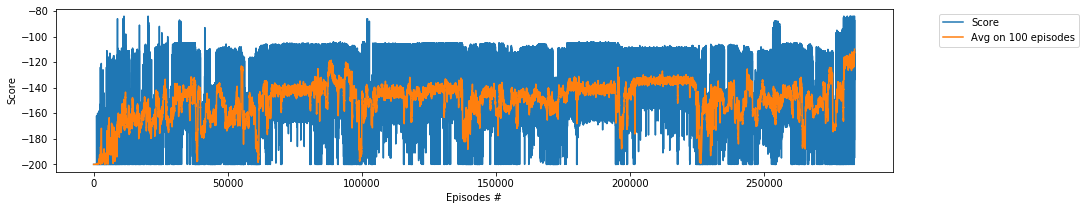

In [3]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [4]:
t = agent.run()
print("Time", t)

Time 110


In [ ]:
agent.close()